<a href="https://colab.research.google.com/github/krusehsbi/ASL_classification/blob/main/less.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LESS: Litter Examination Using Sparse Samples

# TACO-Dataset

The [TACO Dataset](http://*tacodataset*.org) (Trash Annotations in Context) is a publicly available dataset designed for computer vision applications focused on litter detection. It contains real-world images of trash in urban environments and aims to support the development of algorithms for automatic waste recognition.

Each piece of litter is annotated with polygonal masks and bounding boxes. They are categorized into different waste types such as plastic bottles, cigarette butts, and aluminum cans. The annotations follow the [COCO-Format](https://cocodataset.org/#format-data) for Object Detection.

The current version of the Dataset used in this research has **1500** images with **4784** annotations divided into **60** categories and **28** respective supercategories.

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


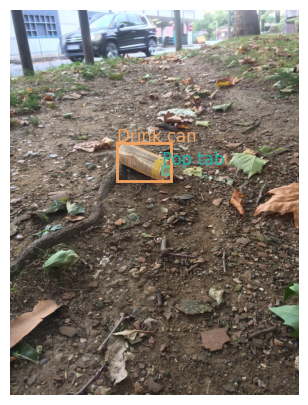

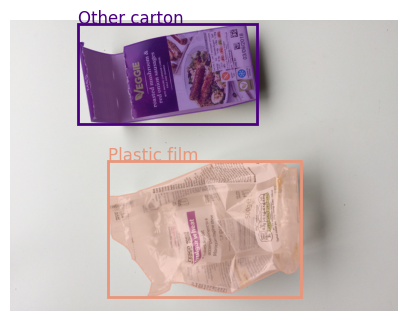

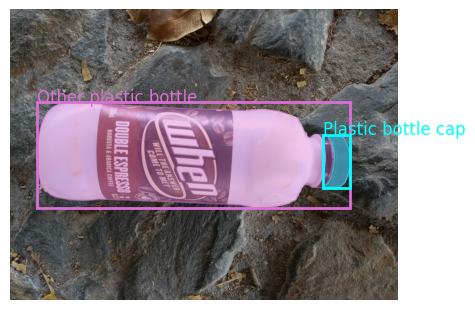

In [45]:
import os
import random
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
from PIL import Image
import numpy as np
import matplotlib.patches as patches
import matplotlib.colors as mcolors

img_dir = '/content/drive/MyDrive/TACO'
ann_file = '/content/drive/MyDrive/TACO/annotations.json'

# Load COCO
coco = COCO(ann_file)

# Random color generator for each category
category_ids = coco.getCatIds()
colors = {
    cat_id: mcolors.to_rgb(random.choice(list(mcolors.CSS4_COLORS.values())))
    for cat_id in category_ids
}

# Pick random images
img_ids = coco.getImgIds()
random_ids = random.sample(img_ids, 3)

for img_id in random_ids:
    img_info = coco.loadImgs(img_id)[0]
    image_path = os.path.join(img_dir, img_info['file_name'])
    image = np.array(Image.open(image_path).convert("RGB"))

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    ax = plt.gca()

    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        cat_id = ann['category_id']
        color = colors[cat_id]
        category_name = coco.loadCats(cat_id)[0]['name']

        # Draw bounding box
        bbox = ann['bbox']
        rect = patches.Rectangle(
            (bbox[0], bbox[1]), bbox[2], bbox[3],
            linewidth=2, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        plt.text(bbox[0], bbox[1] - 5, category_name, color=color, fontsize=12)

        # Draw segmentation mask if available
        if 'segmentation' in ann:
            if isinstance(ann['segmentation'], list):
                for seg in ann['segmentation']:
                    poly = np.array(seg).reshape((len(seg) // 2, 2))
                    patch = patches.Polygon(poly, linewidth=1,
                                            edgecolor=color,
                                            facecolor=color,
                                            alpha=0.4)
                    ax.add_patch(patch)
            elif isinstance(ann['segmentation'], dict):  # RLE
                rle = maskUtils.frPyObjects(ann['segmentation'], img_info['height'], img_info['width'])
                mask = maskUtils.decode(rle)
                ax.imshow(mask, alpha=0.4, cmap='cool')

    plt.show()

This interactive visualization helps analyze the distribution of object **categories** and **supercategories** in the TACO dataset annotations. Looking at the distribution of annotations across categories and supercategories, we observe a significant class imbalance within the dataset. A small number of categories dominate the annotation count, while many others appear only a handful of times.
This imbalance is a key challenge in machine learning and highlights the need for few-shot learning techniques.

Few-shot learning helps models generalize better to rare categories, which are crucial in real-world applications like waste detection.

The K parameter in our visualization defines a minimum annotation threshold. Categories with counts above K are highlighted, while those below K are greyed out. Adjusting K helps focus on underrepresented categories, which is essential for addressing the challenges of few-shot learning.

- Try setting `K = 10` or `K = 30` to filter out common classes and focus on the rare ones.


In [44]:
import json
from collections import Counter
import matplotlib.pyplot as plt
from ipywidgets import interact, SelectionSlider
from pycocotools.coco import COCO

ann_file = '/content/drive/MyDrive/TACO/annotations.json'
coco = COCO(ann_file)

def plot_categories(K):
    cat_counts = {}
    supercat_counts = {}

    for ann in coco.anns.values():
        cat_id = ann['category_id']
        cat_info = coco.cats[cat_id]
        cat_name = cat_info['name']
        supercat = cat_info['supercategory']

        cat_counts[cat_name] = cat_counts.get(cat_name, 0) + 1
        supercat_counts[supercat] = supercat_counts.get(supercat, 0) + 1

    # Sort category counts
    sorted_cat = sorted(cat_counts.items(), key=lambda x: x[1], reverse=True)
    cat_names = [x[0] for x in sorted_cat]
    cat_values = [x[1] for x in sorted_cat]
    cat_colors = ['gray' if v <= K else 'skyblue' for v in cat_values]

    # Sort supercategory counts
    sorted_supercat = sorted(supercat_counts.items(), key=lambda x: x[1], reverse=True)
    supercat_names = [x[0] for x in sorted_supercat]
    supercat_values = [x[1] for x in sorted_supercat]
    supercat_colors = ['gray' if v <= K else 'orange' for v in supercat_values]

    # Plotting
    fig, axs = plt.subplots(1, 2, figsize=(10, 8))

    # Categories plot
    axs[0].barh(cat_names, cat_values, color=cat_colors)
    axs[0].set_title('Category Counts')
    axs[0].set_xlabel('Count')
    axs[0].invert_yaxis()

    for label, color in zip(axs[0].get_yticklabels(), cat_colors):
        label.set_color(color)

    # Supercategories plot
    axs[1].barh(supercat_names, supercat_values, color=supercat_colors)
    axs[1].set_title('Supercategory Counts')
    axs[1].set_xlabel('Count')
    axs[1].invert_yaxis()

    for label, color in zip(axs[1].get_yticklabels(), supercat_colors):
        label.set_color(color)

    plt.tight_layout()
    plt.show()

interact(
    plot_categories,
    K=SelectionSlider(
        options=[1, 2, 3, 5, 10, 30, 50],
        value=10,
        description='K:',
        continuous_update=True
    )
)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


interactive(children=(SelectionSlider(description='K:', index=4, options=(1, 2, 3, 5, 10, 30, 50), value=10), …

<function __main__.plot_categories(K)>